In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# XGBoost(迴歸)-last

流程 : 
1.   標記label
2.   刪除不需要的欄位
3.   資料切割
4.   StandardScaler(標準化)
5.   Grid Search CV(超參數)
6.   XGBRegressor(模型預測)
7.   輸出儲存圖檔

In [ ]:
i = 2317
day = -1
split = 0.8

In [ ]:
#df = pd.read_csv(f'/content/drive/MyDrive/BDSE21_Team1/Final_Project_Old/Dataset/Stock_Data/{i}.csv',index_col=0);df

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
df = pd.read_csv('/content/drive/MyDrive/Sentiment_Result_NLP/2317_price_dict.csv')
df = df[(df['date'] > '2016-04-11') & (df['date'] < '2021-06-30')]
# pd.set_option('display.max_colwidth',None)
# pd.set_option('display.max_rows',None)
# for days in [1,5,10,20,60]:
#   df = df.drop(columns=[f'{days}days_price',f'{days}days_self',f'{days}days_twii',f'{days}days_0050',f'{days}days_2330'])
# df = df[['open','high','low','close','volume','ht_dcperiod','ht_dcphase','inphase']]
# df.index = df['date']
#df = df[['open','high','low','close','volume','dict_score']]
# df.index = df['date']
print(df.shape)
df.head()

(1271, 9)


,date,open,high,low,close,volume,lstm_label,dict_score,bert
1544,2016-04-12,72.996482,73.710382,72.461057,73.174957,13434080,2.0,6.0,1.0
1545,2016-04-13,73.442669,74.781234,73.442669,74.691994,29533680,2.0,1.0,1.0
1546,2016-04-14,74.067337,74.781237,73.531906,73.531906,20081600,-2.0,3.0,1.0
1547,2016-04-15,73.353431,74.245811,72.907246,73.978096,16226320,NaN,NaN,NaN
1548,2016-04-18,74.245819,74.245819,73.621154,73.710388,12326160,NaN,NaN,NaN


In [ ]:
# 檢視欄位是否有nan
pd.isna(df['lstm_label']) 
df['bert']=df['bert'].fillna(0)
#df = df.replace('NaN', 0)

In [ ]:
df.head()

,date,open,high,low,close,volume,lstm_label,dict_score,bert
1544,2016-04-12,72.996482,73.710382,72.461057,73.174957,13434080,2.0,6.0,1.0
1545,2016-04-13,73.442669,74.781234,73.442669,74.691994,29533680,2.0,1.0,1.0
1546,2016-04-14,74.067337,74.781237,73.531906,73.531906,20081600,-2.0,3.0,1.0
1547,2016-04-15,73.353431,74.245811,72.907246,73.978096,16226320,NaN,NaN,0.0
1548,2016-04-18,74.245819,74.245819,73.621154,73.710388,12326160,NaN,NaN,0.0


In [ ]:
#df=df.drop(columns=['date','lstm_label','dict_score'])
df=df.drop(columns=['bert'])

In [ ]:
# 隔日收盤價標記為label
df['label']=df['close'].shift(day)
# 刪除最後一筆沒有label的資料
df = df.iloc[:day,:]
# 移除日期與Nan欄位
# df = df.drop(columns=['date'])
# df = df[['open','high','low','close','volume','']]
# df = df.drop(columns=['acos', 'asin','cosh','exp','sinh','date'])
# 檢視所有欄位是否有nan
# pd.set_option('display.max_rows',None)
# df.isnull().sum()

In [ ]:
df

,open,high,low,close,volume,label
1544,72.996482,73.710382,72.461057,73.174957,13434080,74.691994
1545,73.442669,74.781234,73.442669,74.691994,29533680,73.531906
1546,74.067337,74.781237,73.531906,73.531906,20081600,73.978096
1547,73.353431,74.245811,72.907246,73.978096,16226320,73.710388
1548,74.245819,74.245819,73.621154,73.710388,12326160,72.728767
...,...,...,...,...,...,...
2809,105.606672,106.088894,104.642227,104.642227,21910960,107.535561
2810,105.124449,108.017783,104.642227,107.535561,27710302,108.982224
2811,107.535557,109.946668,107.053335,108.982224,31065987,108.982224
2812,109.946668,110.911112,108.982224,108.982224,35574740,107.535561


In [ ]:
# 資料切割
X, y = df.iloc[:,:-1],df.iloc[:,-1]
train_size = int(len(X.index) * 0.80)  # test半年
X_train, X_test = X.iloc[:train_size,:], X.iloc[train_size:,:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
df_validation = df.sample(frac=1-split)
df_training = df.append(df_validation)
df_training = df_training.drop_duplicates(keep=False)
df_training_ans = df_training['label']
df_validation_ans = df_validation['label']
df_training = df_training.drop(columns='label')
df_validation = df_validation.drop(columns='label')
y_test = y_test.reset_index(drop=True)

# 標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
df_training = sc.fit_transform(df_training)
df_validation = sc.transform(df_validation)
# # PCA降維(暫時不使用)
# from sklearn.decomposition import PCA
# pca = PCA(n_components=100)
# X_train = pca.fit_transform(X_train)
# X_test = pca.fit_transform(X_test)

# # xgboost 套件的資料結構DMatrix(Xgboost原生介面用)
# data_dmatrix = xgb.DMatrix(X_train,y_train)

In [ ]:
# 自定義GridSearchCV(可用於各類套件EX : Keras、sklearn、XGBoost、LightGBM)
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, # 設定使用的CPU內核(-1意味著我們使用所有可用的CPU內核)
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [ ]:
# 用GridSearchCV尋找最佳超參數
from sklearn.model_selection import GridSearchCV
model = xgb.XGBRegressor()
# 設定要最佳化的參數
param_grid = {
    'booster': ['gblinear'],        # 線性模型   參數說明 : 有兩中模型可以選擇gbtree和gblinear。gbtree使用基於樹的模型進行提升計算，gblinear使用線性模型進行提升計算。預設值為gbtree。
    'objective': ['reg:linear'],      # 線性迴歸   參數說明 : 指定學習任務和相應的學習目標或要使用的自定義目標函數。
    'n_estimators': [100,200,300,400],   #        參數說明 : 梯度提升樹的數量。
    'colsample_bytree': [0.3,0.4,0.5],    #        參數說明 : Subsample ratio of columns when constructing each tree.
    'max_depth': [1,5,10,15,20,25],        #        參數說明 : 最大樹深度。
    'reg_alpha': [0.6,0.7,0.8,0.9],     #        參數說明 : L2 正則的懲罰係數。 
    'reg_lambda': [0.6,0.7,0.8,0.9],    #        參數說明 : L1 正則的懲罰係數。
    'subsample': [0.3,0.4,0.5,0.6]     #        參數說明 : Subsample ratio of the training instance.比率,若將其設置為 0.5 意味著 XGBoost 將在種植樹木之前隨機採樣一半的訓練數據。這將防止過度擬合。子採樣將在每次提升迭代中發生一次。
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)
# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 5 folds for each of 4608 candidates, totalling 23040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 1382 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 2514 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3974 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 5754 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 7862 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 10290 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 13046 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 16122 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 19526 tasks      | elapsed: 11.2min


[04:40:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5.762850571697347
{'booster': 'gblinear', 'colsample_bytree': 0.3, 'max_depth': 1, 'n_estimators': 200, 'objective': 'reg:linear', 'reg_alpha': 0.6, 'reg_lambda': 0.6, 'subsample': 0.3}


[Parallel(n_jobs=-1)]: Done 23040 out of 23040 | elapsed: 13.3min finished


In [ ]:
# 使用最佳參數進行預測
from xgboost import plot_importance
import matplotlib.pyplot  as plt
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from xgboost import XGBRegressor
params = model.best_params_
model1 = xgb.XGBRegressor(booster= params['booster'],
            objective= params['objective'],
            n_estimators= params['n_estimators'],
             colsample_bytree= params['colsample_bytree'],
             max_depth= params['max_depth'],
            reg_alpha= params['reg_alpha'],
            reg_lambda= params['reg_lambda'],
           subsample= params['subsample']
           )

model1.fit(X_train, y_train)

# 對測試集進行預測
ans = model1.predict(X_test)
# RMSE是一種非常常見的評價指標 它的範圍可以是0到無窮大 值越低越好
rmse = np.sqrt(mean_squared_error(y_test, ans))
print("RMSE 為%f" % (rmse))
print("R square of Train data:",model1.score(X_train,y_train))
print("R square of Test data:",model1.score(X_test,y_test))

[04:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE 為3.718734
R square of Train data: 0.967644608317602
R square of Test data: 0.9531936244990007


In [ ]:
with open("file.txt", "w") as output:
    output.write(str(result))

<function matplotlib.pyplot.show>

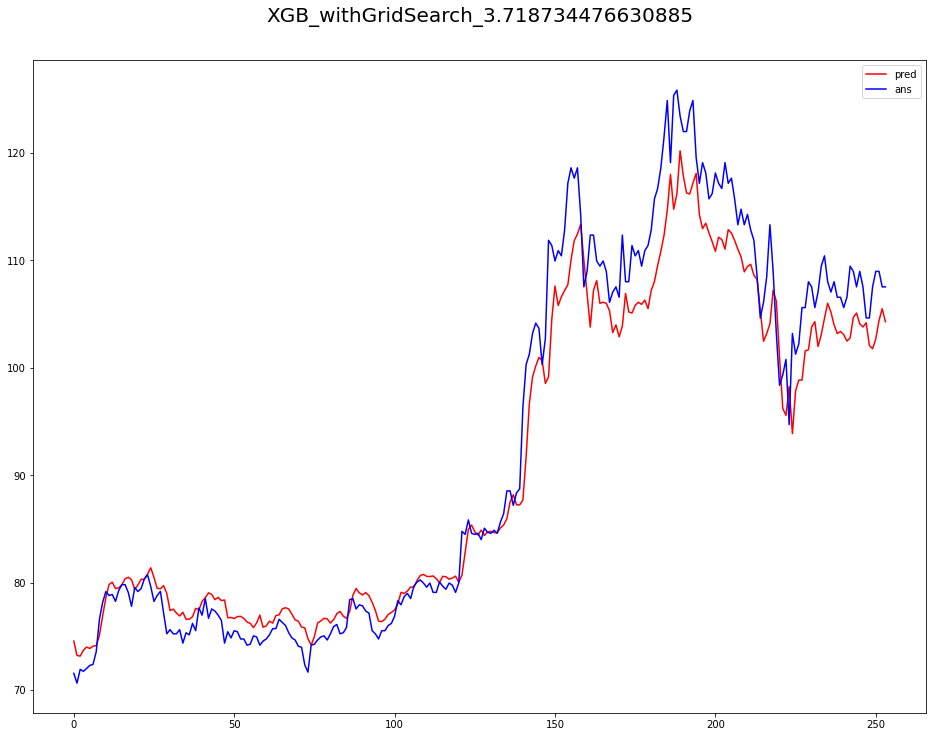

In [ ]:
# 輸出並儲存圖檔
plt.figure(figsize=(16,12))
plt.plot(ans,color='red',label='pred')
plt.plot(y_test.to_numpy(),color='blue',label='ans')
plt.legend(loc='best')
plt.title(f'XGB_withGridSearch_{rmse}', y=1.05, size=20)
plt.savefig('/content/drive/MyDrive/Sentiment_Result_NLP/5_sent_predict.png')
# plt.savefig(f'{i}_{day}_XGBwithGridSearch')
plt.show